In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

2024-05-02 12:29:28.446948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 12:29:28.447057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 12:29:28.448973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 12:29:28.461817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 12:29:30.845958: W tensorflow/comp

In [3]:
import pandas as pd

def try_encoding(dataset_path, encoding):
    try:
         df = pd.read_csv(dataset_path, encoding=encoding)
         print(f"Encoding '{encoding}' worked!")
         return df
    except UnicodeDecodeError:
         print(f"Encoding '{encoding}' failed.")

# Common encodings to try:
encodings = ['latin-1', 'windows-1252', 'iso-8859-1', 'utf-16']

dataset_path = "/home/yadagiri/train_dataset.csv"

for encoding in encodings:
    df = try_encoding(dataset_path, encoding)
    if df is not None:
        break  # We found the encoding


Encoding 'latin-1' worked!


In [4]:
# Load dataset
dataset_path = "/home/yadagiri/train_dataset.csv"
df = pd.read_csv(dataset_path, encoding='latin-1')

X = list(df['text'])
#y = np.asarray(d1[d1.columns[1:]])
y_data = df[df.columns[12:13]]
y = y_data.values
######### Label Encoding for y_train & y_test################
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y
# Split dataset into train and validation sets
train_X, val_X, train_y, val_y = train_test_split(X,y, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=100):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # import pdb;pdb.set_trace()
        text = self.texts[idx]
        label = self.labels[idx]  # Convert label to integer
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


/home/yadagiri/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
import pandas as pd
import numpy as np

# ... (Your existing code to load or create your DataFrame) ...

def get_data_type(value):
    """Determines the data type of a value."""
    try:
        # Try converting to integer
        int(value)
        return 'int'
    except ValueError:
        try:
            # Try converting to float
            float(value)
            return 'float'
        except ValueError:
            # If neither int nor float, it's a string
            return 'str'

# Add the new column with data types
df['data_type'] = df['text'].apply(get_data_type)


In [6]:
print(df['data_type'].value_counts())

data_type
str    12150
Name: count, dtype: int64


In [7]:
df = df[df['data_type'] != 'float']

In [8]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    """Performs common text preprocessing steps.

    Args:
        text (str): The input text string.

    Returns:
        list: A list of preprocessed tokens.
    """

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]

    # Stemming (Optional)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(w) for w in tokens]

    # Lemmatization (Optional)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # Remove punctuation, numbers, etc. (Optional)
    tokens = [re.sub(r'[^\w\s]', '', w) for w in tokens]

    return tokens # This line is important!

# Load your CSV
# data_path = "/content/drive/MyDrive/Colab Notebooks/AI Detect/sentenclength (1).csv"
# df = pd.read_csv(data_path)

# Apply preprocessing to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

# Save the preprocessed CSV
df.to_csv("/home/yadagiri/bertpreprocessed.csv", index=False)
print("Preprocessed CSV saved!")

[nltk_data] Downloading package punkt to /home/yadagiri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yadagiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yadagiri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessed CSV saved!


In [9]:
y

array([1, 1, 1, ..., 1, 0, 1])

In [10]:
# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
# Define training parameters
batch_size = 8
epochs = 3
learning_rate = 2e-5

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

In [11]:
# Create DataLoader for train and validation sets
train_dataset = CustomDataset(train_X, train_y, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_X, val_y, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()


/home/yadagiri/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
val_y

array([1, 1, 1, ..., 1, 0, 1])

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize empty lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0
    train_predicted_labels = []
    train_true_labels = []
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct_train_preds += (predicted == labels).sum().item()
        total_train_preds += labels.size(0)
        train_predicted_labels.extend(predicted.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())

    # Calculate training accuracy and loss for the epoch
    train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_precision = precision_score(train_true_labels, train_predicted_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_predicted_labels, average='weighted')
    train_f1 = f1_score(train_true_labels, train_predicted_labels, average='weighted')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0
    val_predicted_labels = []
    val_true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct_val_preds += (predicted == labels).sum().item()
            total_val_preds += labels.size(0)
            val_predicted_labels.extend(predicted.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy and loss for the epoch
    val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds
    val_precision = precision_score(val_true_labels, val_predicted_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_predicted_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_predicted_labels, average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train Precision: {train_precision}, Train Recall: {train_recall}, Train F1: {train_f1}")
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val F1: {val_f1}")


Epoch 1/3, Train Loss: 0.14154763852654278, Train Accuracy: 0.9582304526748971, Train Precision: 0.9544130391592155, Train Recall: 0.9582304526748971, Train F1: 0.9544854890041672
Val Loss: 0.1178436411688668, Val Accuracy: 0.9753086419753086, Val Precision: 0.9745647097362022, Val Recall: 0.9753086419753086, Val F1: 0.9739568203488184
Epoch 2/3, Train Loss: 0.07204337545460734, Train Accuracy: 0.9754115226337449, Train Precision: 0.9747312087175796, Train Recall: 0.9754115226337449, Train F1: 0.9749845363299987
Val Loss: 0.07803933223524502, Val Accuracy: 0.9777777777777777, Val Precision: 0.9777976074286828, Val Recall: 0.9777777777777777, Val F1: 0.9762793497892835
Epoch 3/3, Train Loss: 0.042449331878425284, Train Accuracy: 0.9853909465020576, Train Precision: 0.9850690737598568, Train Recall: 0.9853909465020576, Train F1: 0.9851318641128187
Val Loss: 0.12955922823460386, Val Accuracy: 0.9798353909465021, Val Precision: 0.9796101364522416, Val Recall: 0.9798353909465021, Val F1: 0.

In [14]:
import os
import torch

# Define the directory path
directory = 'home/yadagiri/POS-TAGS'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, 'Roberta_model.pth')

# Save the model
torch.save(model.state_dict(), file_path)

print(f"Model saved at: {file_path}")


Model saved at: home/yadagiri/POS-TAGS/Roberta_model.pth


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
# Load test dataset
test_dataset_path = "/home/yadagiri/test_dataset.csv"
test_df = pd.read_csv(test_dataset_path)
X = list(test_df['text'])
# #y = np.asarray(d1[d1.columns[1:]])
y_data = test_df[test_df.columns[12:13]]
y = y_data.values
######### Label Encoding for y_train & y_test################
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
test_df['label'] = label_encoder.fit_transform(test_df['label'])

# Create DataLoader for test set
test_dataset = CustomDataset(test_df['text'], test_df['label'], tokenizer)  # Assuming 'binary_label' is the name of the label column
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate model on test set
model.eval()
test_loss = 0
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Test Loss: 0.13476246992282348, Test Accuracy: 0.978275181040158
Precision: 0.9808027923211169, Recall: 0.9961006735200284, F1 Score: 0.9883925430882871
Confusion Matrix:
[[ 162   55]
 [  11 2810]]


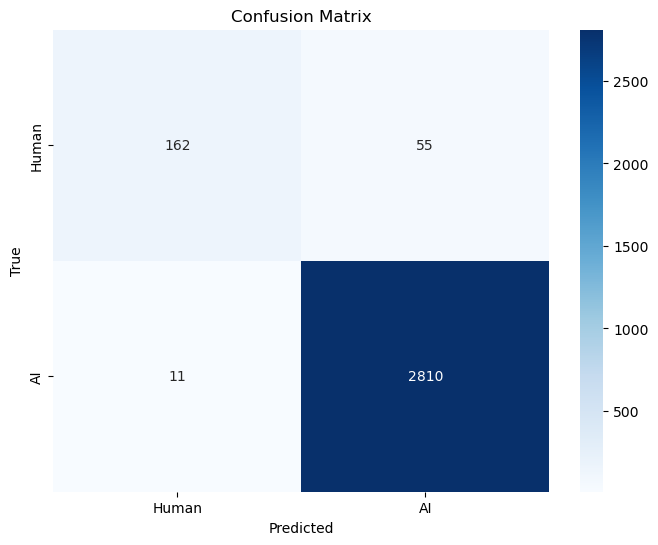

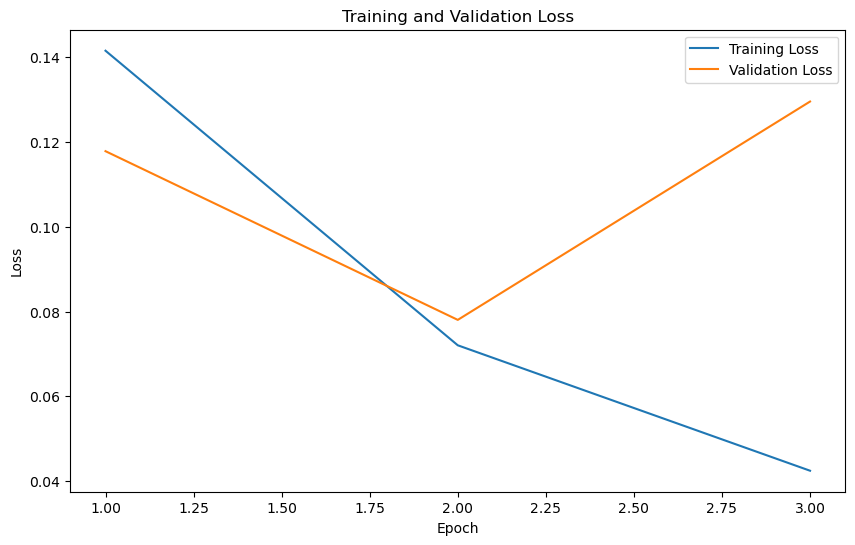

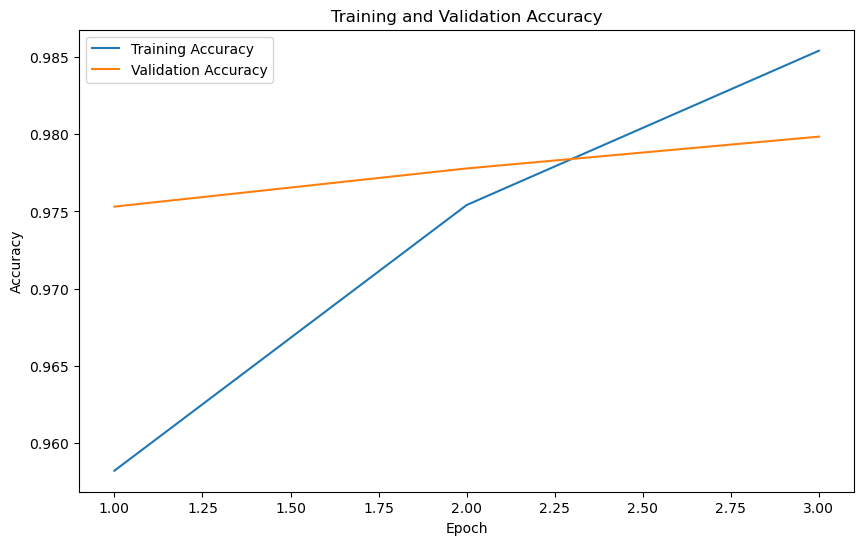

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for test set
y_true = test_df['label']
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
class_names = ['Human', 'AI']  # Rename '0' to 'Hate' and '1' to 'Not Hate'
plot_confusion_matrix(y_true, y_pred, labels=class_names)
# plot_confusion_matrix(y_true, y_pred, labels=['0', '1'])  # Replace labels with actual class labels if different

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
